In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
el_prices = pd.read_excel(r'C:\TIO4317_spring25_project\TIO4317_spring25_project\data\Processed\ice_electric-ave_price-2015-2025.xlsx')
el_prices.set_index('Trade date', inplace=True)

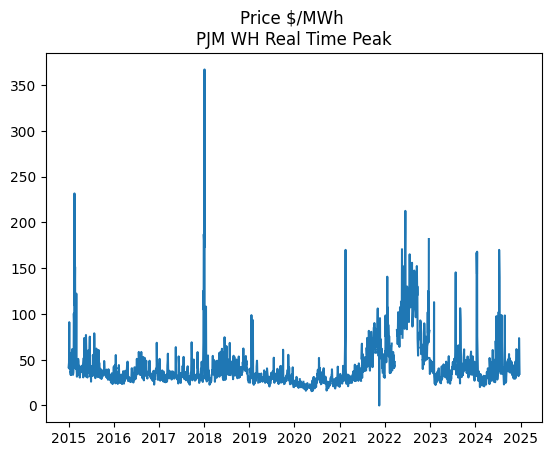

In [6]:
#1 Exploratory analysis 
plt.figure()
plt.plot(el_prices["Price $/MWh \nPJM WH Real Time Peak"])
plt.title("Price $/MWh \nPJM WH Real Time Peak")
plt.show()

#Mye spikes; antagelig vinter demand. Mer volatilt etter 2021 

In [7]:
#Define series with set frequency 
#el_price_mid_C = el_prices["Price $/MWh \nMid C Peak"].asfreq('B')
el_price_PJM = el_prices["Price $/MWh \nPJM WH Real Time Peak"].asfreq('B')
el_price = el_price_PJM.interpolate(method='nearest').dropna() 

In [8]:
#2 Stationarity
from statsmodels.tsa.stattools import adfuller


In [ ]:
#el_price_PJM.isna().sum()
#na_indices = el_price_PJM[el_price_PJM.isna()].index
#print(na_indices)
#el_prices.columns

#Dette feltet var for å undersøke missing values. 

In [9]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    if result[1] < 0.05:
        print("Conclusion: The series is likely stationary.")
    else:
        print("Conclusion: The series is likely non-stationary.")

In [10]:
adf_test(el_price)

ADF Statistic: -4.7867
p-value: 0.0001
Critical Values:
   1%: -3.4329
   5%: -2.8627
   10%: -2.5674
Conclusion: The series is likely stationary.


Conclusion of a likely stationary price series is not expected. 
Therefore, another test is made to verify if this could be the case: KPSS-test

In [11]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series):
    result = kpss(series.dropna(), regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend stationarity
    print(f'KPSS Statistic: {result[0]}')
    print(f'P-value: {result[1]}')
    print(f'Critical Values: {result[3]}')
    if result[1] < 0.05:
        print("Reject null hypothesis: The series is likely non-stationary.")
    else:
        print("Fail to reject null hypothesis: The series is likely stationary.")

In [12]:
kpss_test(el_price)

KPSS Statistic: 1.121576119326783
P-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Reject null hypothesis: The series is likely non-stationary.


C:\Users\endre\AppData\Local\Temp\ipykernel_3616\2214210753.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend stationarity


This test concludes that the series is non-stationary as would be expected. 
Next, the tests for differenced value of the electricity price is tested. 

In [13]:
el_price_diff = el_price.diff().dropna().asfreq('B')

In [14]:
adf_test(el_price_diff)
print("---------------------------")
kpss_test(el_price_diff)


ADF Statistic: -14.5007
p-value: 0.0000
Critical Values:
   1%: -3.4329
   5%: -2.8627
   10%: -2.5674
Conclusion: The series is likely stationary.
---------------------------
KPSS Statistic: 0.030600630755135447
P-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Fail to reject null hypothesis: The series is likely stationary.


C:\Users\endre\AppData\Local\Temp\ipykernel_3616\2214210753.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend stationarity


The differenced series is likely stationary. Therefore, d=1 in ARIMA. 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error,mean_absolute_error

#ACF og PACF plots can guide parameter selection. 

p → Autoregressive (AR) term (from PACF plot)

d → Number of differences needed to achieve stationarity

q → Moving average (MA) term (from ACF plot) 


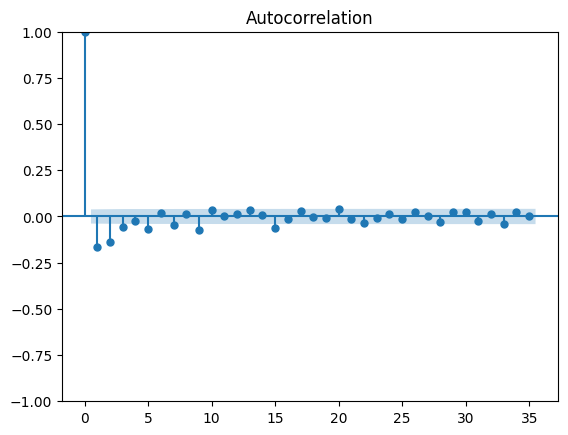

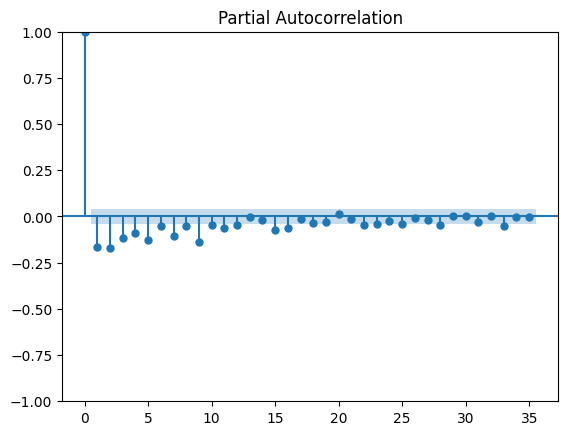

In [16]:
plot_acf(el_price_diff.dropna())
plot_pacf(el_price_diff.dropna())
plt.show()

The ACF plot indicates that 4 lags of MA terms could be significant, and the PACF indicates that 9 lags of AR terms could be significant. Including all of these lags would give an overspecified model. Using information criteria will help to further specify appropriate amount of lags. 

In [77]:
def arima_info_criteria(y, d=0, max_p=5, max_q=5):
    results = []

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(y, order=(p, d, q)).fit()
                
                # Check convergence explicitly
                if not model.mle_retvals.get("converged", True):
                    continue

                results.append({
                    "p": p,
                    "q": q,
                    "AIC": model.aic,
                    "BIC": model.bic,
                    "HQIC": model.hqic
                })
            except:
                continue

    results_df = pd.DataFrame(results)
    return results_df  


results_df = arima_info_criteria(el_price_diff)
AIC_result = results_df.sort_values("AIC")
BIC_result = results_df.sort_values("BIC")


c:\Users\endre\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\endre\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\endre\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\endre\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. 

In [78]:
AIC_result.head()

,p,q,AIC,BIC,HQIC
22,3,4,20866.819938,20919.596259,20885.941336
17,2,5,20869.012692,20921.789013,20888.134091
29,5,2,20870.035465,20922.811786,20889.156863
26,4,5,20870.606533,20935.110925,20893.977131
16,2,4,20871.065557,20917.977843,20888.062356


In [79]:
BIC_result.head()

,p,q,AIC,BIC,HQIC
7,1,1,20874.734689,20898.190832,20883.233089
8,1,2,20876.526914,20905.847092,20887.149913
13,2,1,20876.544602,20905.864780,20887.167601
14,2,2,20874.194339,20909.378553,20886.941938
19,3,1,20876.794418,20911.978632,20889.542017


In [ ]:
#Model 1 ARIMA(1,1,1)
p,d,q = 1,1,1

model = ARIMA(el_price, order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Price $/MWh 
PJM WH Real Time Peak   No. Observations:                 2603
Model:                                 ARIMA(1, 1, 1)   Log Likelihood              -10433.376
Date:                                Sun, 06 Apr 2025   AIC                          20872.753
Time:                                        17:10:04   BIC                          20890.345
Sample:                                    01-02-2015   HQIC                         20879.127
                                         - 12-24-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6464      0.009     71.382      0.000       0.629       0.664
ma.

In [72]:
#Model 2 ARIMA(3,1,4)
p,d,q = 3,1,4

model = ARIMA(el_price, order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Price $/MWh 
PJM WH Real Time Peak   No. Observations:                 2603
Model:                                 ARIMA(3, 1, 4)   Log Likelihood              -10424.420
Date:                                Sun, 06 Apr 2025   AIC                          20864.839
Time:                                        17:10:52   BIC                          20911.751
Sample:                                    01-02-2015   HQIC                         20881.836
                                         - 12-24-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8521      0.119     -7.169      0.000      -1.085      -0.619
ar.

In [86]:
#How many dates are in a year: 
np.average(el_price.index.year.value_counts())

np.float64(260.3)

In [ ]:
#Model 3 SARIMA(1,0,1)(1,0,0)s=260 
#Considering that the date one year ago could help explain current price. 

p,d,q = 1,1,1

P,D,Q,s = 1,0,0,260

model = ARIMA(el_price[2000:], order=(p, d, q),seasonal_order=(P,D,Q,s))
model_fit = model.fit()

print(model_fit.summary())

c:\Users\endre\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                       SARIMAX Results                                        
Dep. Variable:     Price $/MWh 
PJM WH Real Time Peak   No. Observations:                  603
Model:                 ARIMA(1, 1, 1)x(1, 0, [], 260)   Log Likelihood               -2491.762
Date:                                Sun, 06 Apr 2025   AIC                           4991.524
Time:                                        17:28:37   BIC                           5009.125
Sample:                                    09-02-2022   HQIC                          4998.375
                                         - 12-24-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6312      0.026     23.831      0.000       0.579       0.683
ma.

In [ ]:
#Using s=260 is computationally difficult, so tried taking s = 65 and increasing the lag to 4. 
#Also, the approach did not have a significant coefficient --> makes sense that the day before is more correlated than one year ago. 

p,d,q = 1,1,1

P,D,Q,s = 4,0,0,65

model = ARIMA(el_price[2000:], order=(p, d, q),seasonal_order=(P,D,Q,s))
model_fit = model.fit()

print(model_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Price $/MWh 
PJM WH Real Time Peak   No. Observations:                  603
Model:                  ARIMA(1, 1, 1)x(4, 0, [], 65)   Log Likelihood               -2486.193
Date:                                Sun, 06 Apr 2025   AIC                           4986.386
Time:                                        20:49:16   BIC                           5017.188
Sample:                                    09-02-2022   HQIC                          4998.375
                                         - 12-24-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6319      0.028     22.790      0.000       0.578       0.686
ma.

In [ ]:
#Another approach: dummy variables for specifying the time of year. 
#separate summer and winter months. 

df = pd.DataFrame({'price': el_price})
df['month'] = df.index.month

# Define summer and winter months 
summer_months = [6, 7, 8]
winter_months = [12,1,2]
# Create a dummy variable for summer
df['is_summer'] = df['month'].isin(summer_months).astype(int)
df['is_winter'] = df['month'].isin(winter_months).astype(int)


endog = el_price
exog = df[['is_summer',"is_winter"]]

p,d,q = 1,1,1

model = ARIMA(endog, order=(p, d, q),exog=exog)
model_fit = model.fit()

print(model_fit.summary()) 


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2603
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10433.204
Date:                Sun, 06 Apr 2025   AIC                          20876.407
Time:                        21:35:28   BIC                          20905.727
Sample:                    01-02-2015   HQIC                         20887.030
                         - 12-24-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_summer     -0.3914      1.915     -0.204      0.838      -4.144       3.361
is_winter      1.2155      3.520      0.345      0.730      -5.683       8.114
ar.L1          0.6454      0.009     69.123      0.0

## Residual diagnostics 

In [ ]:
#Residual diagnostics. 

## Forecast and model performance

### Model 1: ARIMA(1,1,1)

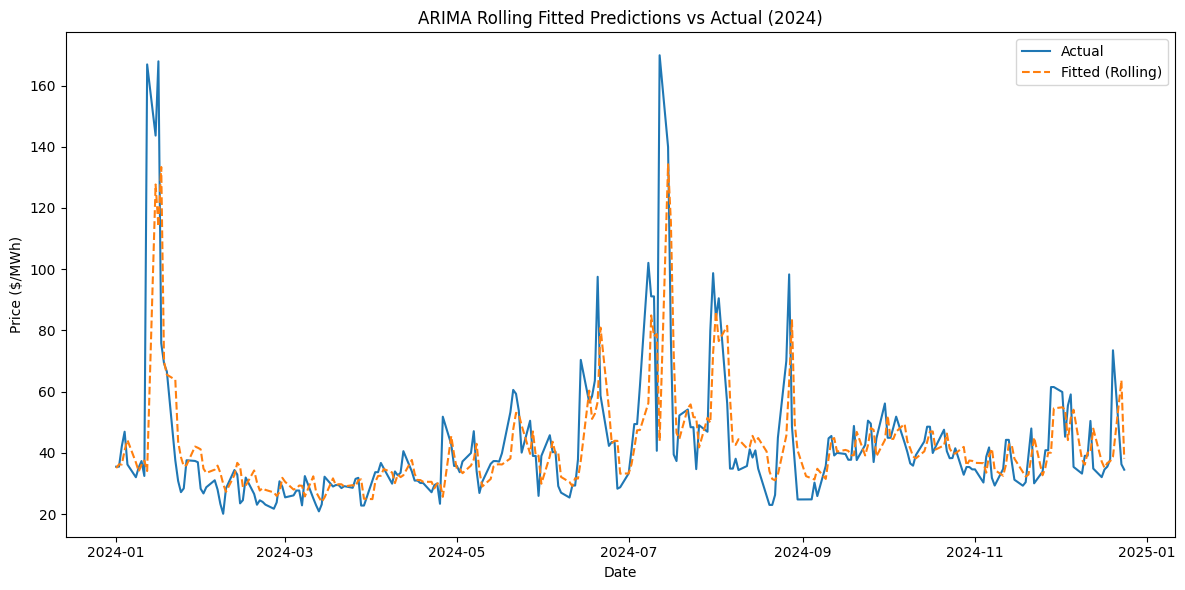

In [74]:
train = el_price[:'2023-12-31']
test = el_price['2024-01-01':]

p,d,q = 1,1,1


history = list(train)
predictions = []

# Rolling forecast
for t in range(len(test)):
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)[0]
    predictions.append(forecast)

    # Add the actual value from test to history
    history.append(test.iloc[t])

# Convert to series for plotting
pred_series_1 = pd.Series(predictions, index=test.index)


plt.figure(figsize=(12,6))
plt.plot(test, label='Actual')
plt.plot(pred_series_1, label='Fitted (Rolling)', linestyle='--')
plt.title('ARIMA Rolling Fitted Predictions vs Actual (2024)')
plt.xlabel('Date')
plt.ylabel('Price ($/MWh)')
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
#Forecast evaluation. 

mse = mean_squared_error(test, pred_series_1)
mae = mean_absolute_error(test, pred_series_1)
rmse = np.sqrt(mse)
print(f'Rolling Fitted MSE: {mse:.2f}')
print(f'Rolling Fitted MAE: {mae:.2f}')
print(f'Rolling Fitted RMSE: {rmse:.2f}')

Rolling Fitted MSE: 278.04
Rolling Fitted MAE: 8.64
Rolling Fitted RMSE: 16.67


In [76]:
naive_pred = test.shift(1).dropna()  # yesterday = today forecast
naive_true = test[1:]                # actuals aligned

naive_mae = mean_absolute_error(naive_true, naive_pred)
naive_rmse = np.sqrt(mean_squared_error(naive_true, naive_pred))

print(f'Naive MAE: {naive_mae:.2f}')
print(f'Naive RMSE: {naive_rmse:.2f}')

Naive MAE: 8.63
Naive RMSE: 17.71


### Model 2 ARIMA(3,1,4)

c:\Users\endre\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


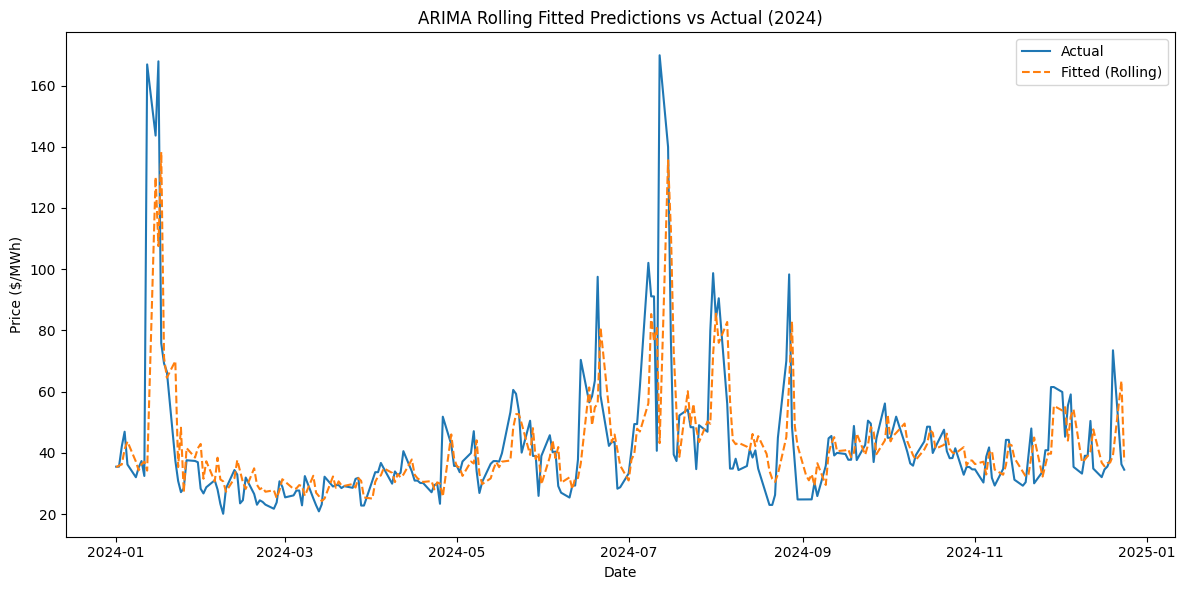

In [69]:
train = el_price[:'2023-12-31']
test = el_price['2024-01-01':]

p,d,q = 3,1,4


history = list(train)
predictions = []

# Rolling forecast
for t in range(len(test)):
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)[0]
    predictions.append(forecast)

    # Add the actual value from test to history
    history.append(test.iloc[t])

# Convert to series for plotting
pred_series_2 = pd.Series(predictions, index=test.index)


plt.figure(figsize=(12,6))
plt.plot(test, label='Actual')
plt.plot(pred_series_2, label='Fitted (Rolling)', linestyle='--')
plt.title('ARIMA Rolling Fitted Predictions vs Actual (2024)')
plt.xlabel('Date')
plt.ylabel('Price ($/MWh)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
mse = mean_squared_error(test, pred_series_2)
mae = mean_absolute_error(test, pred_series_2)
rmse = np.sqrt(mse)
print(f'Rolling Fitted MSE: {mse:.2f}')
print(f'Rolling Fitted MAE: {mae:.2f}')
print(f'Rolling Fitted RMSE: {rmse:.2f}')

Rolling Fitted MSE: 278.04
Rolling Fitted MAE: 8.64
Rolling Fitted RMSE: 16.67


### Model 3: Winter and Summer Dummies. 

In [126]:
train_df = df[:'2023-12-31']
test_df = df['2024-01-01':]

p,d,q = 1,1,1

history_y = list(train_df['price'])
#history_x = list(train_df[['is_summer',"is_winter"]])

history_x = train_df[['is_summer',"is_winter"]]


predictions = []

# Rolling forecast
for t in range(len(test_df)):
    next_exog = test_df[['is_summer', 'is_winter']].iloc[t:t+1]

    
    if len(history_x) != len(history_y):
        print(f"Length mismatch at step {t}: history_x = {len(history_x)}, history_y = {len(history_y)}")
        break

    model = ARIMA(history_y, order=(p, d, q),exog=history_x)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1,exog=next_exog).iloc[0]
    predictions.append(forecast)

    # Add the actual value from test to history
    history_y.append(test_df['price'].iloc[t])
    history_x = pd.concat([history_x, next_exog])


# Convert to series for plotting
pred_series_3 = pd.Series(predictions, index=test.index)



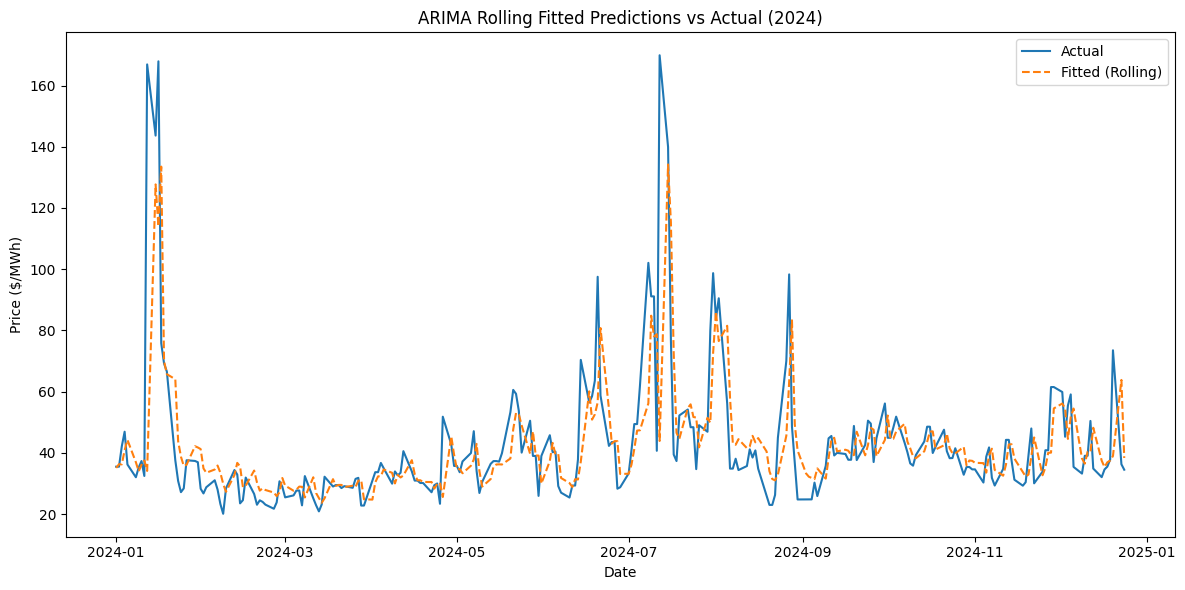

In [127]:
plt.figure(figsize=(12,6))
plt.plot(test, label='Actual')
plt.plot(pred_series_3, label='Fitted (Rolling)', linestyle='--')
plt.title('ARIMA Rolling Fitted Predictions vs Actual (2024)')
plt.xlabel('Date')
plt.ylabel('Price ($/MWh)')
plt.legend()
plt.tight_layout()
plt.show()

In [128]:
mse = mean_squared_error(test, pred_series_3)
mae = mean_absolute_error(test, pred_series_3)
rmse = np.sqrt(mse)
print(f'Rolling Fitted MSE: {mse:.2f}')
print(f'Rolling Fitted MAE: {mae:.2f}')
print(f'Rolling Fitted RMSE: {rmse:.2f}')

Rolling Fitted MSE: 268.74
Rolling Fitted MAE: 8.50
Rolling Fitted RMSE: 16.39


### Foreløpig det under er testing med log og litt eksperimentering 


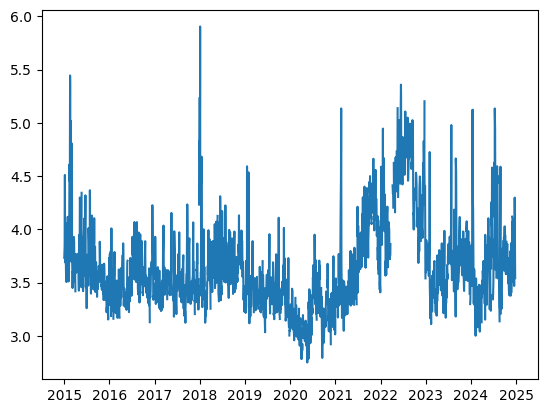

In [23]:
df = pd.DataFrame(el_price)
df["Log_Values"] = np.log(df["Price $/MWh \nPJM WH Real Time Peak"].replace(0, np.nan))
el_price_log = df["Log_Values"].asfreq('B')
el_price_log

plt.plot(el_price_log)
#plt.plot(el_price)


In [24]:
df['Diff_Value_Log'] = df['Log_Values'].diff()

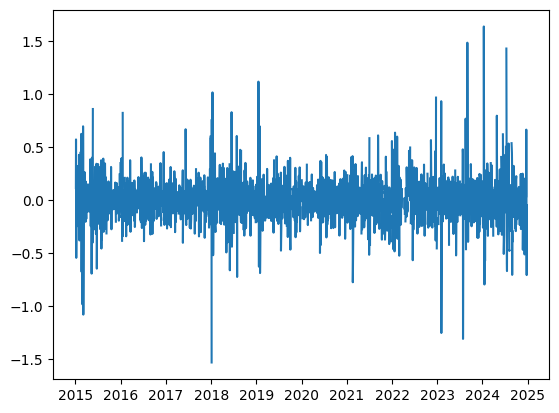

In [25]:
log_diff_PJM = df["Diff_Value_Log"].asfreq('B')
plt.plot(log_diff_PJM)

In [26]:
adf_test(log_diff_PJM)
kpss_test(log_diff_PJM)

ADF Statistic: -20.6489
p-value: 0.0000
Critical Values:
   1%: -3.4332
   5%: -2.8628
   10%: -2.5674
Conclusion: The series is likely stationary.
KPSS Statistic: 0.04588074794090207
P-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Fail to reject null hypothesis: The series is likely stationary.


C:\Users\endre\AppData\Local\Temp\ipykernel_12252\2214210753.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend stationarity


In [27]:
p = 3
d = 1 
q = 3

model = ARIMA(el_price_log, order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Log_Values   No. Observations:                 2603
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 575.020
Date:                Sat, 05 Apr 2025   AIC                          -1136.040
Time:                        15:52:37   BIC                          -1094.992
Sample:                    01-02-2015   HQIC                         -1121.168
                         - 12-24-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0703      6.468     -0.011      0.991     -12.747      12.606
ar.L2          0.3291      2.806      0.117      0.907      -5.170       5.828
ar.L3          0.0397      0.643      0.062      0.9

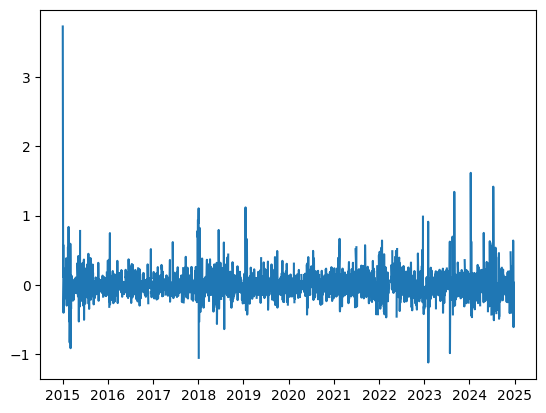

In [28]:
#model_fit.plot_diagnostics(figsize=(10, 6))
residuals = model_fit.resid
plt.plot(residuals)
plt.show()

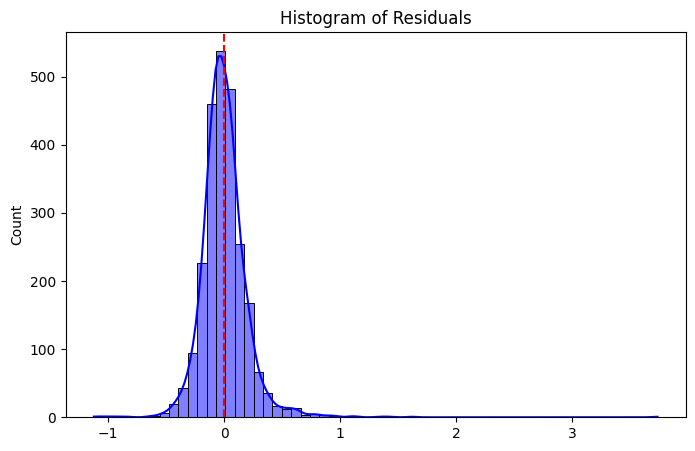

In [29]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=60, color='blue')
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Histogram of Residuals")
plt.show()

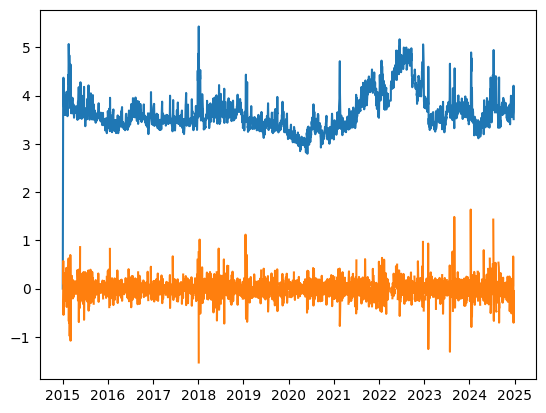

In [30]:
fitted_values = model_fit.fittedvalues
plt.plot(fitted_values)
plt.plot(log_diff_PJM)


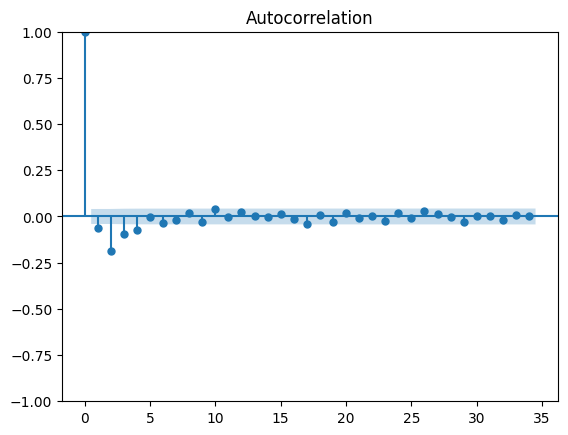

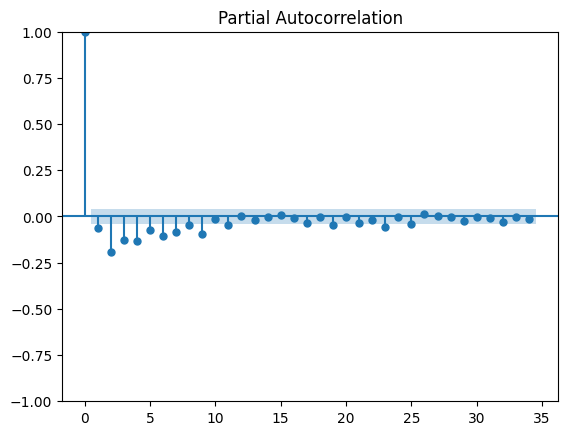

In [31]:
plot_acf(log_diff_PJM.dropna())
plot_pacf(log_diff_PJM.dropna())
plt.show()